# Alzheimer's Disease Neuroimaging Initiative

In [32]:
from IPython.core.display import HTML
with open("project.css") as css:
    styles = css.read()
HTML(styles)

## ADNI

The overarching goal of the Alzheimer's Disease Neuroimaging Initiative (ADNI) is to identify biomarkers of Alzheimer’s disease. Specifically the study aims at identifying those biomarkers that can be used in the earliest (pre-dementia) prediction of Alzheimer's Disease (AD). The study began in 2004, a time when biomarkers for Alzheimer’s disease which could be used for diagnostics in pre-dementia individuals were virtually unknown. There are four categories of biomarkers in the scope of the initiative: (clinical, imaging, genetic, and biochemical).

There have been ADNI 4 study phases to date with the following goals:

<!-- Begin ADNI Phase table -->

| Study Phase | Goal | Dates | Cohort |
|:---: |:--- |:--- | --- |
| ADNI 1 | Develop biomarkers as outcome measures for clinical trials | 2004-2009 | 200 elderly controls<br>400 MCI<br>200 AD |
| ADNI GO | Examine biomarkers in earlier stages of disease | 2009-2011 | Existing ADNI-1 +<br>200 early MCI |
| ADNI 2 | Develop biomarkers as predictors of cognitive decline, and as outcome measures | 2011-2016 | Existing ADNI-1 and ADNI-GO +<br>150 elderly controls<br>100 early MCI<br>150 late MCI<br>150 AD |
| ADNI 3 | Study the use of tau PET and functional imaging techniques in clinical trials | 2016 - present | Existing ADNI-1, ADNI-GO, ADNI-2 +<br>133 elderly controls<br>151 MCI<br>87 AD |

<!-- End ADNI phase table -->

## ADNI Data
Before looking at a single observation or feature, there is a lot of information we can glean from reviewing ADNI metadata. There are over 250 datasets in the ADNI data inventory spanning the 4 study phases (ADNI 1, GO, 2, 3) - and this number does not include the archives. These studies are longitudinal. ADNI-1 started in 2004 and ADNI-3 continues today. Although there is potentially a wealth of information, insights, and predictive power in these data, their data collection methods and longitudinal nature present many challenges.

One challenge is that all biometrics within the scope of the study are not collected across all study phases. Also, within each phase, not all participants had all measurements taken. For example, in ADNI-1, $100\%$ of the cohort had a 1.5 Tesla (1.5T) MRI, $50\%$ had a PET scan. Of the $50\%$ that didn't have a PET scan, $25\%$ had a 3T MRI. Finally, only $20\%$ of the ADNI-1 cohort had a lumbar puncture (L.P.) to collect cerebral spinal fluid (CSF).

Other data challenges are related to the longitudinal nature of the studies across the different phases. In each successive phase of the study, participants were rolled over from previous phases while new participants were also added - *(cohort details can be seen in the table above)*. However, existing participants in the study must provide their consent to be included in each subsequent phase. Furthermore, an obvious, but nonetheless real, complication with this population is that a participant could be removed from the study at any time due to significant deterioration in health or death. 

The result is that each phase of the study produces a richer set of longitudinal data than the previous study because of the rollover participants. The downside of this design is the inherent introduction of missingness into the data due to the recently joined participants.

### An initial look at the data.
Given the breadth of available data and the challenges mentioned above, deciding what data to use to start EDA is a non-trivial task. Fortunately, there is a combined dataset available consisting of key ADNI tables merged into a single table based on the patient identifier or `RID`. As is common with most ADNI datasets, each observation represents a single visit for a participant. This means that a single participant (`RID`) may appear multiple times in the dataset. The number of occurrences will generally depend on what phase the participant entered the study.

Let's take an initial look at the merged dataset.

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix

In [59]:
adni_merge = pd.read_csv('../data/ADNIMERGE.csv', low_memory=False)

In [60]:
print("The shape of the dataset is {}.".format(adni_merge.shape))
print("There are {} unique participants in the dataset."
      .format(len(adni_merge.RID.unique())))
print("There is an average of {:.2f} rows in the data per participant."
      .format(len(adni_merge)/len(adni_merge.RID.unique())))

The shape of the dataset is (13632, 113).
There are 2081 unique participants in the dataset.
There is an average of 6.55 rows in the data per participant.


As seen above, the dataset contains $2081$ unique study participants spanning $13632$ visits. The data is longitudinal based on participant visits spaced roughly six months apart. The `VISCODE` feature represents the visit in which the measurements and evaluations were captured. The initial evaluation measurements are identified by `VISCODE` = `'bl'`, which stands for baseline. Below are the unique `VISCODE` values in the dataset:

In [61]:
adni_merge.sort_values(by='Month')['VISCODE'].unique()

array(['bl', 'm03', 'm06', 'm12', 'm18', 'm24', 'm36', 'm30', 'm42',
       'm48', 'm54', 'm60', 'm66', 'm72', 'm78', 'm84', 'm90', 'm96',
       'm102', 'm108', 'm114', 'm120', 'm126', 'm132', 'm144', 'm156'],
      dtype=object)

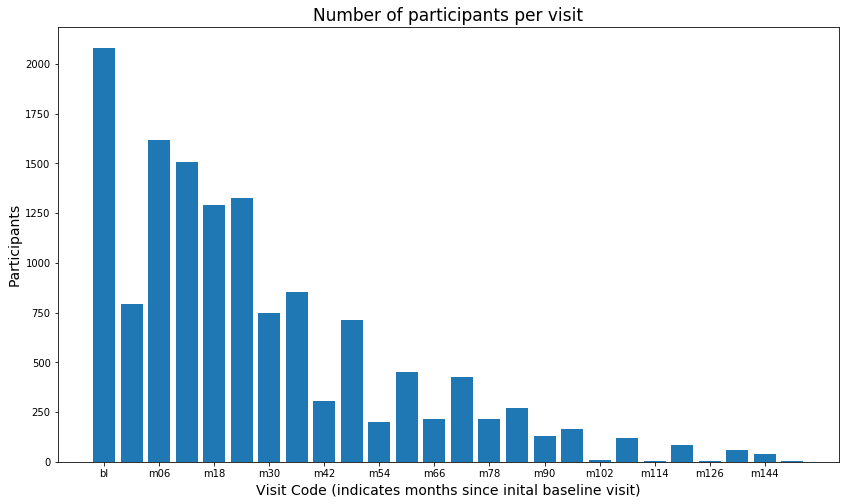

In [62]:
# M represents months since the last visit (0 = baseline/initial visit)
adni_by_month = adni_merge.groupby(by='M').count()
particpants = adni_by_month['RID']
visits = adni_merge.sort_values(by='M')['VISCODE'].unique()

fig, ax = plt.subplots(1, 1, figsize=(14,8))

ax.set_title('Number of participants per visit', size=17)
ax.set_xticks(range(0, 26, 2))
ax.set_xlabel('Visit Code (indicates months since inital baseline visit)', size=14)
ax.set_ylabel('Participants', size=14)
ax.bar(visits, particpants)

plt.show()

Based on the design of the study as discussed above, we expect there to be a lot of missing data in this data set. Let's take a look.

In [63]:
# How much missing data do we have per column?
def calculate_missing_data(data): 
    """Calculates the number of and percentage of missing values per column.
    
    data - Dataframe from which to calculate missing data.
    
    Return: A dataframe with count and percentage of missing values per colummn.
    """
    cols_with_nulls = data.columns[data.isnull().any()]

    idx = []
    missing = []
    missing_pct = []

    for col in cols_with_nulls:
        idx.append(col)
        missing.append(len(data[col][data[col].isnull()]))
        missing_pct.append(100 * len(data[col][data[col]
                                                   .isnull()])/len(data[col]))

    missing_df = pd.DataFrame(np.array([missing, missing_pct]).T, 
                              index=idx, columns=['Num Missing', 'Pct. Missing'])
    missing_df = missing_df.sort_values(by=['Pct. Missing'], ascending=False)
    
    print("Out of {0} features in the dataset, {1} have missing values."
     .format(len(data.columns), len(missing_df)))
    print("\nQuartiles of missing data:")
    print(missing_df.quantile([.25, .5, .75, 1]))
    
    return missing_df

In [39]:
# Calculate missing data
missing_data = calculate_missing_data(adni_merge)

Out of 113 features in the dataset, 93 have missing values.

Quartiles of missing data:
      Num Missing  Pct. Missing
0.25       3839.0     28.161678
0.50       6185.0     45.371185
0.75       7758.0     56.910211
1.00      13632.0    100.000000


In [40]:
# Look at the top 10 columns in terms of missing values
missing_data.head(10)

,Num Missing,Pct. Missing
FLDSTRENG_bl,13632.0,100.000000
FLDSTRENG,13632.0,100.000000
PIB_bl,13483.0,98.906984
PIB,13409.0,98.364143
PTAU,11262.0,82.614437
ABETA,11261.0,82.607101
TAU,11261.0,82.607101
AV45,11122.0,81.587441
FDG,10125.0,74.273768
DIGITSCOR,9832.0,72.124413


`FLDSTRENG` and `FLDSTRENG_bl` are providing absolutely no information so we can drop them.

In [41]:
adni_merge = adni_merge.drop(labels=['FLDSTRENG', 'FLDSTRENG_bl'], axis=1)

We've noticed that the numbers of non-null values for `PTAU`, `ABETA`, and `TAU` are suspiciously close to the number of unique participants. The fact that these features all have almost the exact same number of missing values could be an artifact of how and when these data were collected. Perhaps these were collected on the initial baseline `bl` visit.

In [42]:
missing_proteins = missing_data.loc[['TAU', 'PTAU', 'ABETA']]
missing_proteins['Num Values Present'] = len(adni_merge) - missing_proteins['Num Missing']
missing_proteins['Num Participants'] = len(adni_merge.RID.unique())
missing_proteins

,Num Missing,Pct. Missing,Num Values Present,Num Participants
TAU,11261.0,82.607101,2371.0,2081
PTAU,11262.0,82.614437,2370.0,2081
ABETA,11261.0,82.607101,2371.0,2081


There are many options to deal with the variable number of visits in the merged data set. Instead of vertically stacking the visits as in the merged dataset, we could split on `VISCODE` and stack the data *horizontally* creating wide rows with many more features. However, this is essentially transposing the data and moving the missing values from deep columns to wide rows. Another option is to split the data into multiple subsets of data based on `VISCODE` and deal with them separately. As shown in the "*Participants per visit*" figure, every participant had at least a baseline visit. This subset should provide the most complete and uniform representation of the data.

In [65]:
baseline = adni_merge[adni_merge['VISCODE'] == 'bl']
print('Shape of the baseline visit subset: ', baseline.shape)

baseline.head()

Shape of the baseline visit subset:  (2081, 113)
2081


There appears to be a lot of columns with similar, if not identical, information such as `TAU`, `TAU_bl`, `AV45`, `AV45_bl`. Let's examine this pattern to see if these pairs are highly correlated.

In [45]:
# Generate a correlation matrix of xxx_bl vs xxx
corr_df = baseline.corr()
cols = baseline.columns
col1, col2, corr = [], [], []

# Specifically check the correlation of xxx_bl to xxx
for col in cols:
    if '_bl' in col.lower(): 
        drop_bl = col[0:-3]
        if (drop_bl in cols):
            if (col in corr_df.index and corr_df.loc[col][drop_bl] > .8):
                col1.append(col)
                col2.append(drop_bl)
                corr.append(corr_df.loc[col][drop_bl])

# Display the results                
bl_corr_df = pd.DataFrame({"Baseline column": col1, 'Alternate column': col2, "Correlation": corr})
bl_corr_df

,Baseline column,Alternate column,Correlation
0,CDRSB_bl,CDRSB,1.0
1,ADAS11_bl,ADAS11,1.0
2,ADAS13_bl,ADAS13,1.0
3,ADASQ4_bl,ADASQ4,1.0
4,MMSE_bl,MMSE,1.0
5,RAVLT_immediate_bl,RAVLT_immediate,1.0
6,RAVLT_learning_bl,RAVLT_learning,1.0
7,RAVLT_forgetting_bl,RAVLT_forgetting,1.0
8,RAVLT_perc_forgetting_bl,RAVLT_perc_forgetting,1.0
9,LDELTOTAL_BL,LDELTOTAL,1.0


These are indeed duplicate columns so we can drop them.

In [46]:
baseline = baseline.drop(labels=bl_corr_df['Baseline column'].values, axis=1)
print("The new shape of the baseline subset is {}.".format(baseline.shape))

The new shape of the baseline subset is (2081, 71).


In [47]:
# Let's see what features we have now
baseline.columns.sort_values()

Index(['ABETA', 'ABETA_bl', 'ADAS11', 'ADAS13', 'ADASQ4', 'AGE', 'APOE4',
       'AV45', 'CDRSB', 'COLPROT', 'DIGITSCOR', 'DX', 'DX_bl', 'EXAMDATE',
       'EXAMDATE_bl', 'EcogPtDivatt', 'EcogPtLang', 'EcogPtMem', 'EcogPtOrgan',
       'EcogPtPlan', 'EcogPtTotal', 'EcogPtVisspat', 'EcogSPDivatt',
       'EcogSPLang', 'EcogSPMem', 'EcogSPOrgan', 'EcogSPPlan', 'EcogSPTotal',
       'EcogSPVisspat', 'Entorhinal', 'FAQ', 'FDG', 'FSVERSION',
       'FSVERSION_bl', 'Fusiform', 'Hippocampus', 'ICV', 'IMAGEUID',
       'LDELTOTAL', 'M', 'MMSE', 'MOCA', 'MidTemp', 'Month', 'Month_bl',
       'ORIGPROT', 'PIB', 'PTAU', 'PTAU_bl', 'PTEDUCAT', 'PTETHCAT',
       'PTGENDER', 'PTID', 'PTMARRY', 'PTRACCAT', 'RAVLT_forgetting',
       'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_perc_forgetting', 'RID',
       'SITE', 'TAU', 'TAU_bl', 'TRABSCOR', 'VISCODE', 'Ventricles',
       'WholeBrain', 'Years_bl', 'mPACCdigit', 'mPACCtrailsB', 'update_stamp'],
      dtype='object')

We still have some columns that look very similar. These may contain non-numeric values such as strings or NaNs, or possibly they are really uncorrelated.

In [48]:
# Columns to check for duplicates
cols = ['ABETA', 'DX', 'EXAMDATE','FSVERSION',  'PTAU', 'TAU']
equiv = []

for col in cols:
    equiv.append(baseline[col].equals(baseline[col+'_bl']))
                 
# Display the results                
bl_dupes = pd.DataFrame({'Baseline column': list(map(lambda x: x + '_bl', cols)),
                            'Alternate column': cols,
                            'Are equal': equiv})
bl_dupes

,Baseline column,Alternate column,Are equal
0,ABETA_bl,ABETA,True
1,DX_bl,DX,False
2,EXAMDATE_bl,EXAMDATE,True
3,FSVERSION_bl,FSVERSION,True
4,PTAU_bl,PTAU,True
5,TAU_bl,TAU,True


All of the pairs are exact duplicates except `DX`|`DX_bl`, so we can drop the duplicate column. Then we'll take a look at `DX` vs.`DX_bl`.

In [49]:
# Get a list of duplicate column names to drop
dupe_cols = list(bl_dupes['Baseline column'].values)

# Remove DX_bl until we investigate further
del dupe_cols[dupe_cols.index('DX_bl')]

# Drop the columns
baseline = baseline.drop(labels=dupe_cols, axis=1)

In [50]:
# See how DX maps to DX_bl
baseline.drop_duplicates('DX_bl')[['DX_bl', 'DX']]

,DX_bl,DX
0,CN,CN
1,AD,Dementia
5,LMCI,MCI
48,SMC,CN
2848,EMCI,MCI
11389,NaN,NaN


Although similar, the diagnoses in `DX_bl` are more specific than those in `DX`. Having the more specific classifications may be useful so we'll keep them and then take another look at our data.

In [51]:
baseline = baseline.drop(labels=['DX'], axis=1)

In [52]:
print("The new shape of the baseline subset is {}.".format(baseline.shape))
calculate_missing_data(baseline)

The new shape of the baseline subset is (2081, 65).
Out of 65 features in the dataset, 46 have missing values.

Quartiles of missing data:
      Num Missing  Pct. Missing
0.25         20.5      0.985103
0.50        614.0     29.505046
0.75        843.5     40.533397
1.00       2061.0     99.038924


,Num Missing,Pct. Missing
PIB,2061.0,99.038924
DIGITSCOR,1267.0,60.884190
AV45,1107.0,53.195579
EcogSPOrgan,891.0,42.815954
ABETA,866.0,41.614608
TAU,866.0,41.614608
PTAU,866.0,41.614608
EcogSPDivatt,865.0,41.566555
EcogSPVisspat,857.0,41.182124
EcogPtOrgan,855.0,41.086016


In the new dataset, it is clear that `PIB` will not be useful and can be removed. PIB or *PiB* stands for **Pi**ttsburgh Compound-**B** - a synthetic radiotracer developed for use in PET scans to visualize and measure A$\beta$ deposits in the brain.

In [53]:
baseline = baseline.drop(labels='PIB', axis=1)

In [54]:
calculate_missing_data(baseline[baseline.TAU.notnull()])

Out of 64 features in the dataset, 35 have missing values.

Quartiles of missing data:
      Num Missing  Pct. Missing
0.25         13.0      1.069959
0.50        207.0     17.037037
0.75        404.0     33.251029
1.00        822.0     67.654321


,Num Missing,Pct. Missing
DIGITSCOR,822.0,67.654321
EcogSPOrgan,436.0,35.884774
EcogSPDivatt,421.0,34.650206
EcogPtOrgan,421.0,34.650206
EcogSPVisspat,413.0,33.991770
EcogSPPlan,409.0,33.662551
AV45,408.0,33.580247
MOCA,407.0,33.497942
EcogPtDivatt,405.0,33.333333
EcogPtVisspat,403.0,33.168724


In [55]:
rids_wo_av45 = baseline[baseline.AV45.isnull()]['RID']
am3 = adni_merge[adni_merge.RID.isin(rids_wo_av45)]
am3 = am3[am3.AV45.notnull()]

In [56]:
len(am3['RID'].unique())

206

In [25]:
len(baseline[baseline.TAU.notnull()])

1215

In [30]:
baseline.columns.sort_values()

Index(['ABETA', 'ADAS11', 'ADAS13', 'ADASQ4', 'AGE', 'APOE4', 'AV45', 'CDRSB',
       'COLPROT', 'DIGITSCOR', 'DX_bl', 'EXAMDATE', 'EcogPtDivatt',
       'EcogPtLang', 'EcogPtMem', 'EcogPtOrgan', 'EcogPtPlan', 'EcogPtTotal',
       'EcogPtVisspat', 'EcogSPDivatt', 'EcogSPLang', 'EcogSPMem',
       'EcogSPOrgan', 'EcogSPPlan', 'EcogSPTotal', 'EcogSPVisspat',
       'Entorhinal', 'FAQ', 'FDG', 'FSVERSION', 'Fusiform', 'Hippocampus',
       'ICV', 'IMAGEUID', 'LDELTOTAL', 'M', 'MMSE', 'MOCA', 'MidTemp', 'Month',
       'Month_bl', 'ORIGPROT', 'PIB', 'PTAU', 'PTEDUCAT', 'PTETHCAT',
       'PTGENDER', 'PTID', 'PTMARRY', 'PTRACCAT', 'RAVLT_forgetting',
       'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_perc_forgetting', 'RID',
       'SITE', 'TAU', 'TRABSCOR', 'VISCODE', 'Ventricles', 'WholeBrain',
       'Years_bl', 'mPACCdigit', 'mPACCtrailsB', 'update_stamp'],
      dtype='object')

In [28]:
baseline.SITE

0         11
1         11
5         22
10        11
15       100
20        22
22        11
26        22
31       100
34        11
39        11
43        11
48        82
50        67
57       100
61        67
64        99
69        23
76       100
77        82
78        18
84        67
86       100
91        99
97        11
101       99
106       67
112       18
116       23
122       67
        ... 
13562    941
13563     19
13567     14
13568    135
13569    135
13570     14
13573    168
13574    941
13575    941
13576    941
13579      3
13580    130
13581    305
13582     33
13585    130
13587     29
13588     98
13592    127
13597    100
13598    100
13599    131
13600     82
13603     14
13610    114
13611     67
13621     20
13627    135
13628     27
13629    127
13631     27
Name: SITE, Length: 2081, dtype: int64